The following script generates a data set and uses lasso to pick a model, with cross-validation to compare different $\lambda$ values (in scikit-learn, ``$\alpha$'').

The data sets are random, so each time you run the results will differ.

In [1]:
import numpy as np
from numpy.random import default_rng
rng = default_rng()

import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer
scoring_func = make_scorer(mean_squared_error,greater_is_better=False)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300


# import pandas as pd
# from itertools import combinations
# from more_itertools import powerset
# import operator

# Generate a data set

We will use scikit-learn's "make_regression" function to generate data using a linear model.  

Then we will split up the data set into training/test sets using scikit-learn's "train_test_split" which picks a random subset for the test set.

The generated model is random (coefficients will change each time you run).  You can pass an integer seed to the random number generator

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.linear_model import Lasso
import numpy as np

n_samples, n_features, n_informative = 100, 40, 20
sigma = 5

#Initialize a random number generator
#pass an integer if you want results to be reproducible
rng = np.random.RandomState() 

X, y,coef_true = make_regression(n_samples, n_features, \
                                 n_informative=n_informative, \
                                 random_state=rng,coef=True, \
                                 noise=sigma, \
                                 effective_rank=n_informative)

print('\nCoefficients in the generative model:')
for i in range(n_features):
    print('\tFeature %2i\'s coefficient: %.2f'%(i,coef_true[i]))
# print(coef_true)

#Split up the big data set into a test set (for final evaluation) and a training set
X_train, X_test, y_train, y_test = train_test_split( X,y, test_size=0.33)




Coefficients in the generative model:
	Feature  0's coefficient: 0.00
	Feature  1's coefficient: 0.00
	Feature  2's coefficient: 16.81
	Feature  3's coefficient: 0.00
	Feature  4's coefficient: 0.00
	Feature  5's coefficient: 0.00
	Feature  6's coefficient: 0.00
	Feature  7's coefficient: 0.00
	Feature  8's coefficient: 61.11
	Feature  9's coefficient: 72.56
	Feature 10's coefficient: 68.88
	Feature 11's coefficient: 53.50
	Feature 12's coefficient: 0.00
	Feature 13's coefficient: 63.40
	Feature 14's coefficient: 33.34
	Feature 15's coefficient: 0.00
	Feature 16's coefficient: 57.70
	Feature 17's coefficient: 0.00
	Feature 18's coefficient: 5.57
	Feature 19's coefficient: 69.14
	Feature 20's coefficient: 0.00
	Feature 21's coefficient: 33.16
	Feature 22's coefficient: 0.00
	Feature 23's coefficient: 62.39
	Feature 24's coefficient: 0.00
	Feature 25's coefficient: 44.12
	Feature 26's coefficient: 0.00
	Feature 27's coefficient: 3.75
	Feature 28's coefficient: 37.26
	Feature 29's coeffi

# Baselines

#### How good is the true model?

In [3]:
#on test data
y_pred = np.matmul(X_test,coef_true)
mse_test_using_coef_true = mean_squared_error(y_test,y_pred)
# print(mse_test_using_coef_true)
print('\n\nTest set MSE using true coefficients: %.2f'%mse_test_using_coef_true)

#on training data
y_pred = np.matmul(X_train,coef_true)
mse_train_using_coef_true = mean_squared_error(y_train,y_pred)
# print(mse_train_using_coef_true)
print('\nTraining set MSE using true coefficients: %.2f'%mse_train_using_coef_true)



Test set MSE using true coefficients: 24.74

Training set MSE using true coefficients: 28.17


#### How good is the intercept alone?  (average Y value in the training set)

In [4]:
#on test data
y_pred = np.ones(y_test.shape)*(np.mean(y_train))
mse_test_just_intercept = mean_squared_error(y_test,y_pred)
# print(mse_test_just_intercept)
print('\nTest set MSE using only the intercept: %.2f'%mse_test_just_intercept)

y_pred = np.ones(y_train.shape)*(np.mean(y_train))
mse_train_just_intercept = mean_squared_error(y_train,y_pred)
print('\nTraining set MSE using only the intercept: %.2f'%mse_train_just_intercept)



Test set MSE using only the intercept: 259.02

Training set MSE using only the intercept: 299.16


#### How good is the ordinary least squares (OLS) solution if we use all (training) data for fitting and no penalty?

In [5]:
scaler = StandardScaler()
lin = LinearRegression(normalize=False,fit_intercept=True) 
pipe = make_pipeline(scaler, lin)

pipe.fit(X_train,y_train)
mse_test_OLS = mean_squared_error(y_test, pipe.predict(X_test))
mse_train_OLS = mean_squared_error(y_train, pipe.predict(X_train))

print('\nTest set MSE using OLS solution: %.2f'%mse_test_OLS)
print('\nTraining set MSE using OLS solution: %.2f'%mse_train_OLS)



Test set MSE using OLS solution: 61.50

Training set MSE using OLS solution: 15.41


#### How good is the ordinary least squares (OLS) solution if we use use cross validation (fit OLS solution to k-1 folds, evaluate on held out fold, then average)

In [6]:
scaler = StandardScaler()
lin = LinearRegression(normalize=False,fit_intercept=True) 
pipe = make_pipeline(scaler, lin)

pipe.fit(X_train,y_train)

parameters = {}
n_folds=5
gs = GridSearchCV(pipe, parameters, \
                  scoring='neg_mean_squared_error', \
                  cv=n_folds)
gs.fit(X_train,y_train)

scores = -gs.cv_results_['mean_test_score']
scores_std = gs.cv_results_['std_test_score']

mse_train_OLS_CV = scores[0] 
#each entry for different parameter, but no paramters passed, so just first entry

print('\nCVTraining set MSE using OLS solution: %.2f'%mse_train_OLS_CV)


CVTraining set MSE using OLS solution: 206.04


#  Lasso

We will use Lasso to fit the training data.  

We will try multiple $\lambda$ values, using held-out data to help pick the choose lambda.  We will use cross-validation to select a $\lambda$.  

Note: scikit-learn uses notation $\alpha$ instead of $\lambda$:$$\arg\min \quad trainMSE + \alpha \sum_{l=1}^p |\beta_l|$$

Instead of multiple for loops, to try different $\lambda$'s in cross-validation, we will use scikit-learn pipelines and gridsearchCV.  

There are alternative ways we can search.  For linear model regularization specifically (lasso and ridge regression), there are specialized ways of avoiding grid search.  You can use those in practice, but the setup here will be useful for non-linear models as well.

In [7]:
#Cross-validation: pick the number of folds
n_folds = 5

#Specify the lambdas we will check.  
n_alphas = 200 
alphas = np.logspace(-5, 5, n_alphas) #grid search for lambda (aka 'alpha')

#Create a scikit-learn 'pipeline' for standardizing the data (scale so unit variance)
#  Then use scikit-learn 'gridsearchCV' with that pipeline in lieu 
#    of having separate for loops.
#  
parameters = { 'lasso__alpha':alphas}

scaler = StandardScaler()
lasso = Lasso(normalize=False,fit_intercept=True) #we will pass through alpha values later
pipe = make_pipeline(scaler, lasso)

print('\n\nParameters in the pipeline you can set:\n')
print(pipe.get_params().keys()) #reports input names can set (look for the hyper-parameters)

#Now do the grid search - one call to fit() tells it to run the 
# pipeline in k-fold CV, in each split fitting for all lambdas
gs = GridSearchCV(pipe, parameters, scoring='neg_mean_squared_error', cv=n_folds)
gs.fit(X_train,y_train)

print('\nDone fitting')



Parameters in the pipeline you can set:

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'lasso', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'lasso__alpha', 'lasso__copy_X', 'lasso__fit_intercept', 'lasso__max_iter', 'lasso__normalize', 'lasso__positive', 'lasso__precompute', 'lasso__random_state', 'lasso__selection', 'lasso__tol', 'lasso__warm_start'])

Done fitting


## Plot the results

Two plots of CV estimates of MSE (averaged over held-out folds) as a function of $\alpha$ (equivalent to $\lambda$).

The scales are log-log.

The second plot is zoomed in.

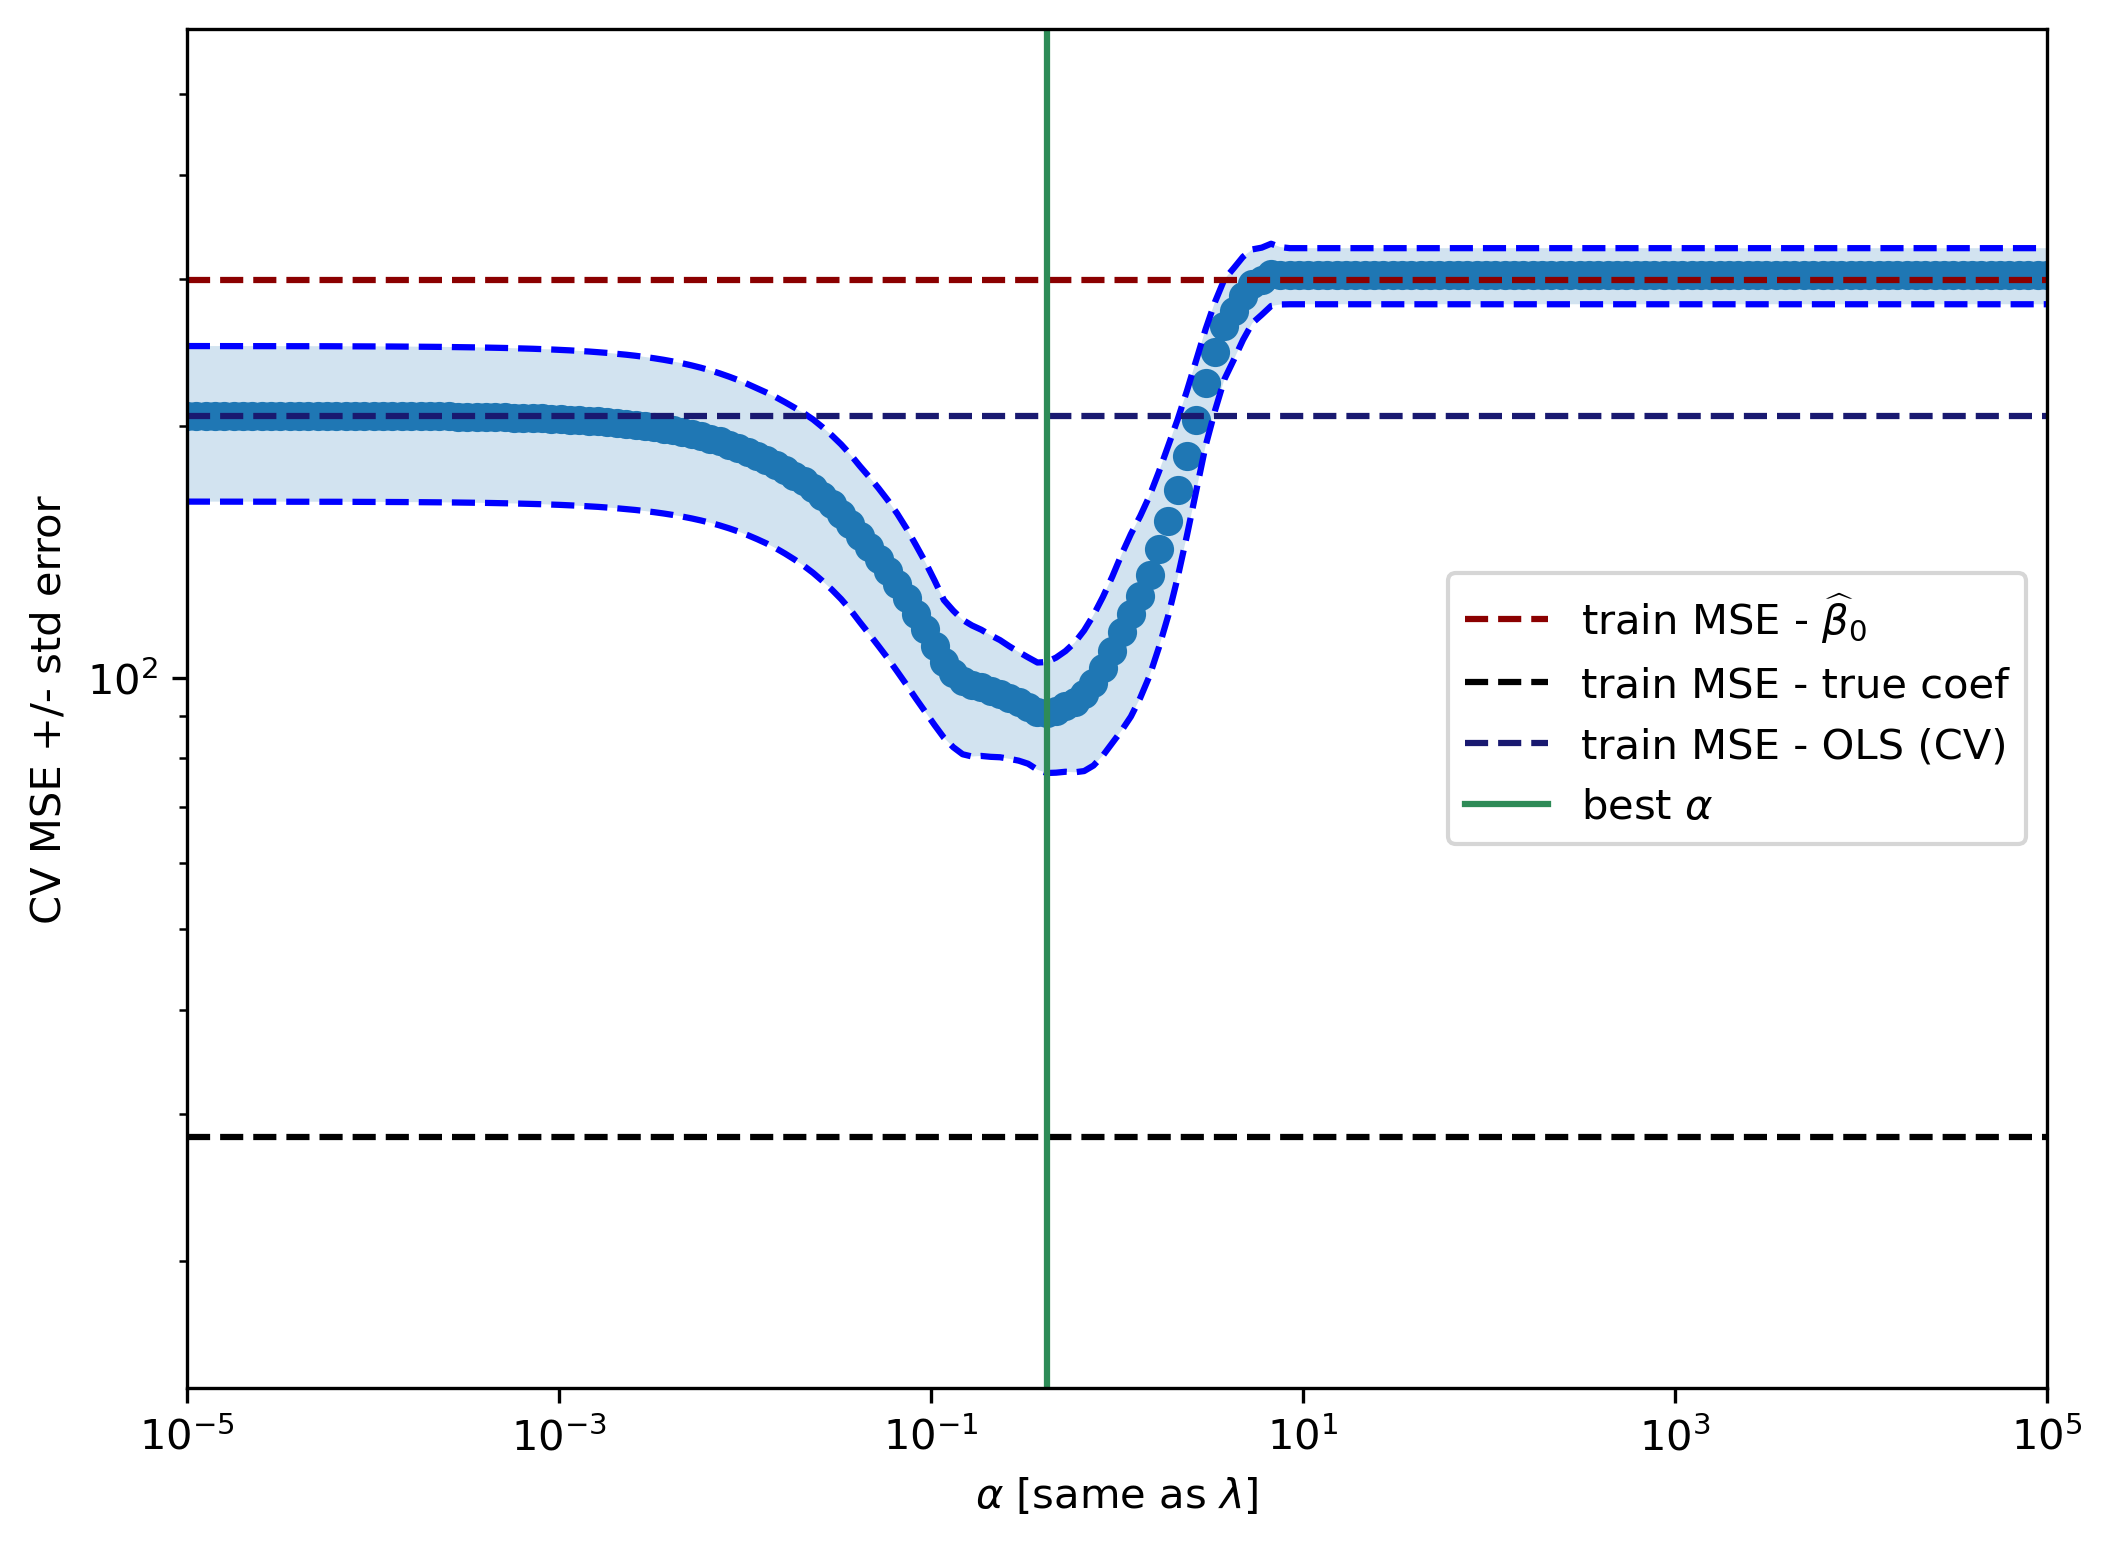

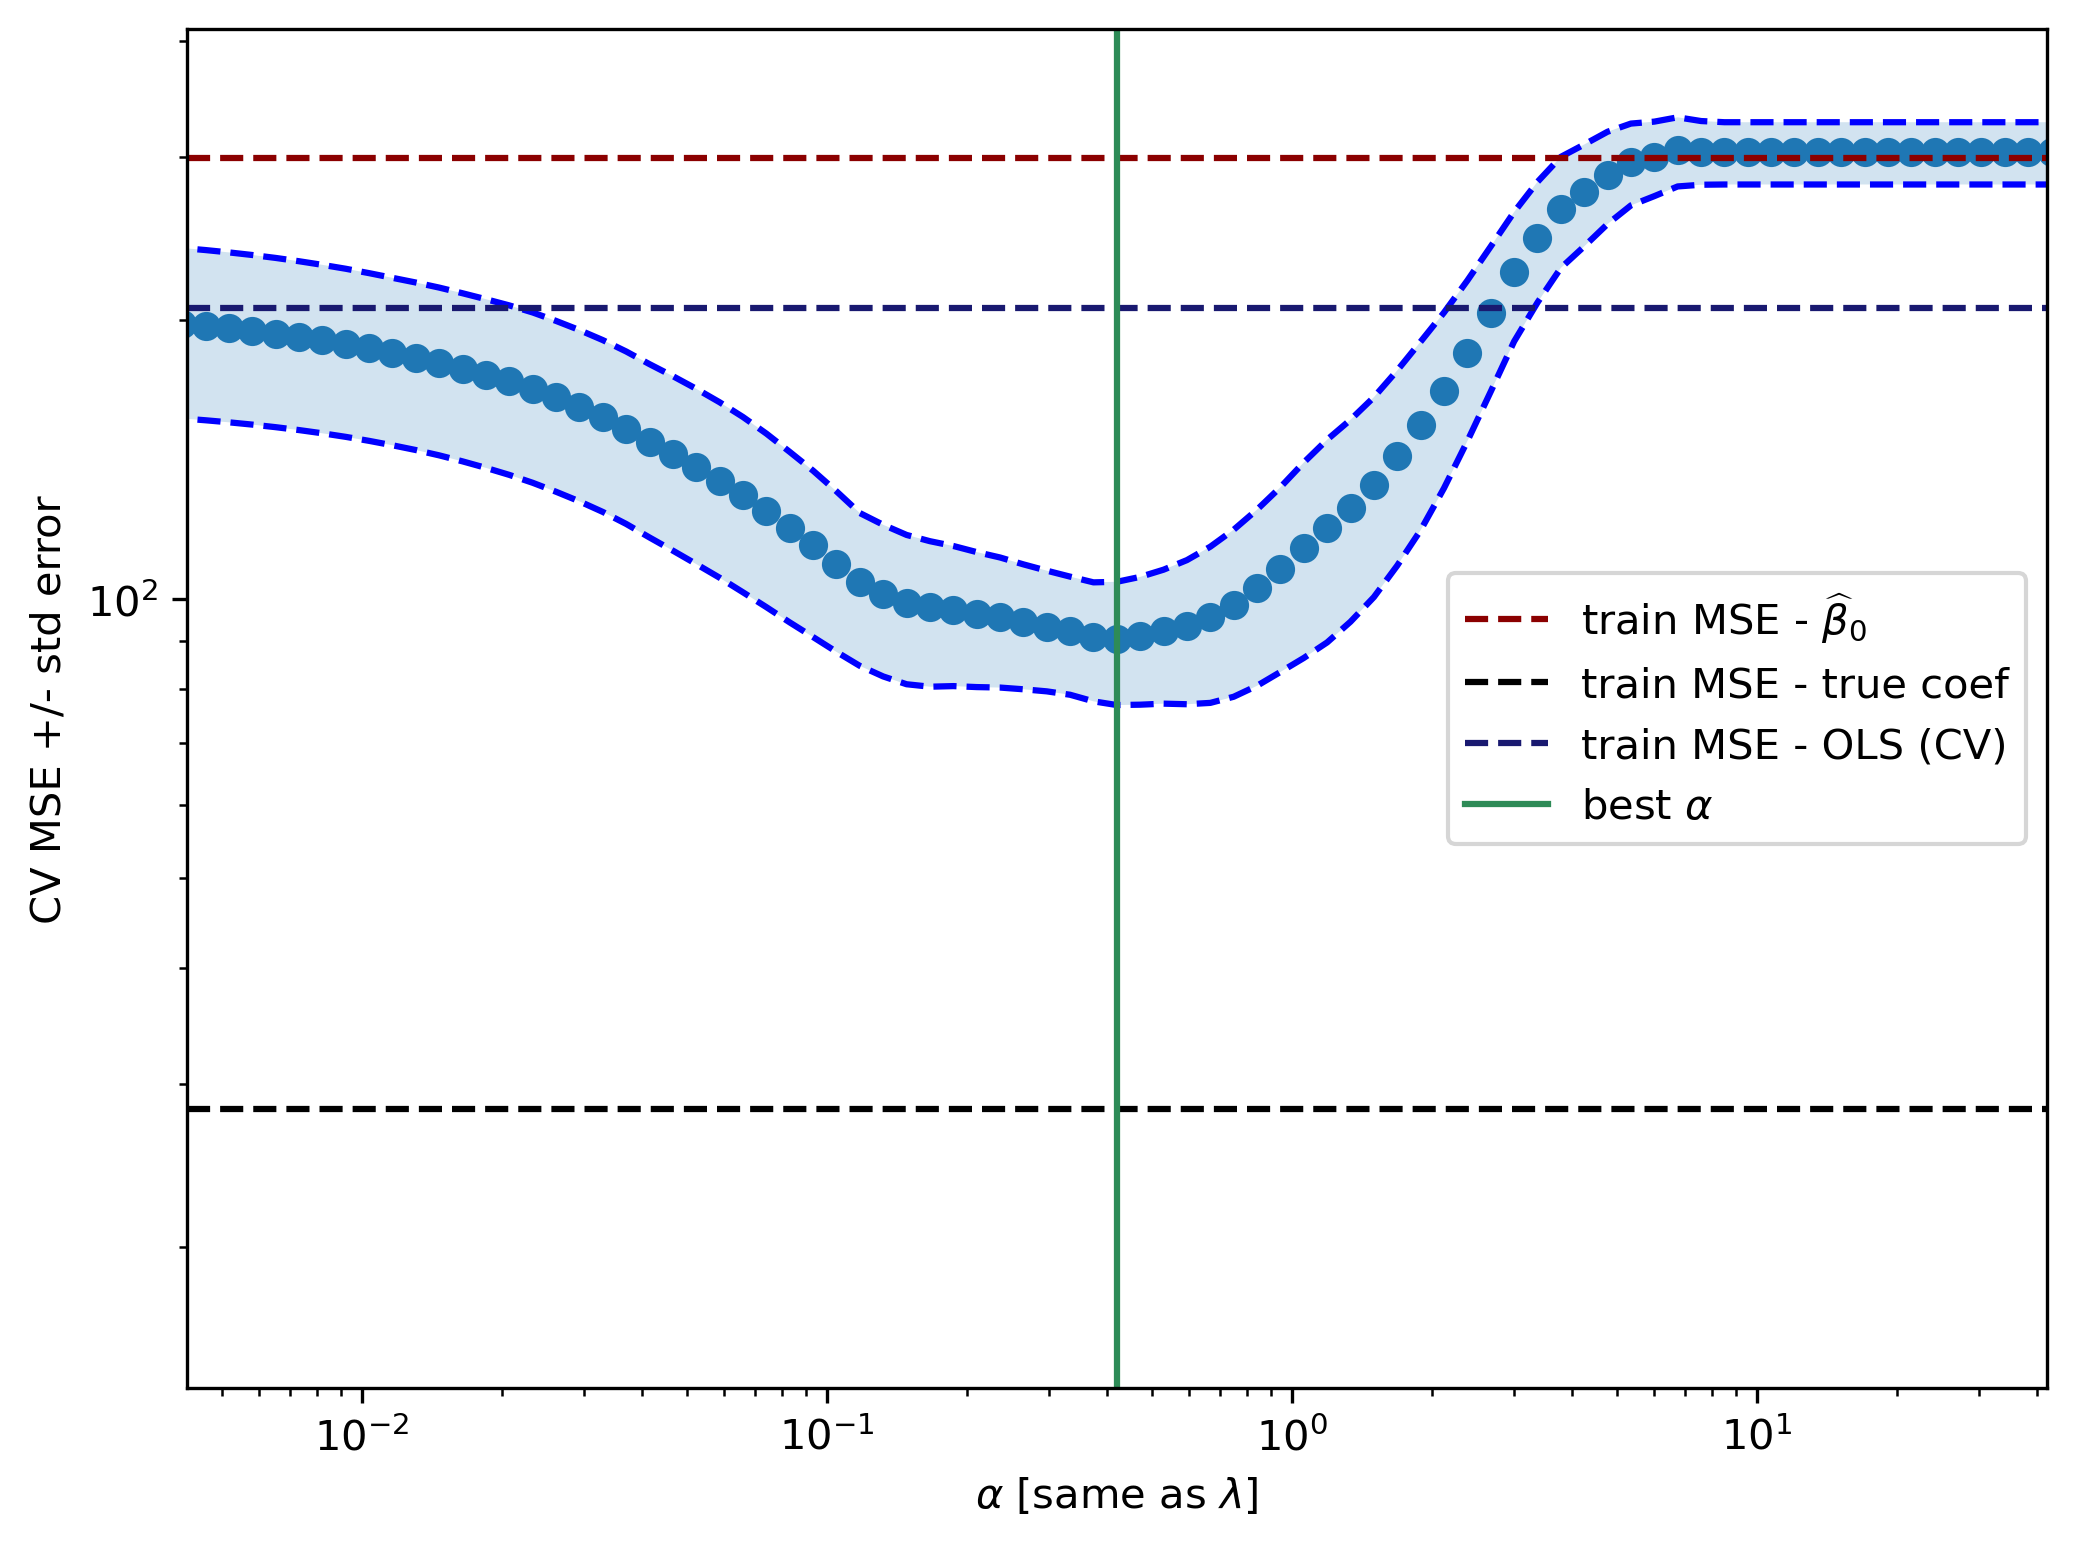

In [8]:
#For the gridcv, it maximizes the negative MSE; scores are negative of what we want
scores = -gs.cv_results_['mean_test_score']
scores_std = gs.cv_results_['std_test_score']
plt.figure().set_size_inches(8, 6)
plt.loglog(alphas, scores,'o')

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.loglog(alphas, scores + std_error, 'b--')
plt.loglog(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV MSE +/- std error')
plt.xlabel(r'$\alpha$ [same as $\lambda$]')


#plot baseline fits for training set
#just intercept
plt.axhline(mse_train_just_intercept, linestyle='--',\
            color='darkred', \
            label=r'train MSE - $\widehat{\beta}_0$')

#true coefficients
plt.axhline(mse_train_using_coef_true, linestyle='--', \
            color='black',label='train MSE - true coef')

#OLS solution (no penalty-- all features)
plt.axhline(mse_train_OLS_CV, linestyle='--', \
            color='midnightblue',label='train MSE - OLS (CV)')

#Mark the value of the best $\alpha$
plt.axvline(alphas[scores.argmin()], linestyle='-', \
            color='seagreen',label=r'best $\alpha$')
plt.xlim([alphas[0], alphas[-1]])
plt.ylim(mse_train_using_coef_true*.5, 2*mse_train_just_intercept)
plt.legend()




#zoom in - same figure
plt.figure().set_size_inches(8, 6)
plt.loglog(alphas, scores,'o')

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.loglog(alphas, scores + std_error, 'b--')
plt.loglog(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV MSE +/- std error')
plt.xlabel(r'$\alpha$ [same as $\lambda$]')


#plot baseline fits for training set
#just intercept
plt.axhline(mse_train_just_intercept, linestyle='--',\
            color='darkred', \
            label=r'train MSE - $\widehat{\beta}_0$')

#true coefficients
plt.axhline(mse_train_using_coef_true, linestyle='--', \
            color='black',label='train MSE - true coef')

#OLS solution (no penalty-- all features)
plt.axhline(mse_train_OLS_CV, linestyle='--', \
            color='midnightblue',label='train MSE - OLS (CV)')

#Mark the value of the best $\alpha$
plt.axvline(alphas[scores.argmin()], linestyle='-', \
            color='seagreen',label=r'best $\alpha$')

plt.xlim(alphas[scores.argmin()]/100,alphas[scores.argmin()]*100)
plt.ylim(mse_train_using_coef_true*.5, 2*scores[0])
plt.legend()

_Side note_: If you look carefully, the dashed red line is _below_ the empirical values.  When we estimated training set MSE for $\widehat{\beta}_0$, it was fitting with the whole training set and then evaluated on that set.  In our grid-search, we estimated the intercept for each split and estimated its MSE on the held-out data.   The dashed red line is overly optimistic.

#### Make a plot of how coefficients change (use the whole training set)

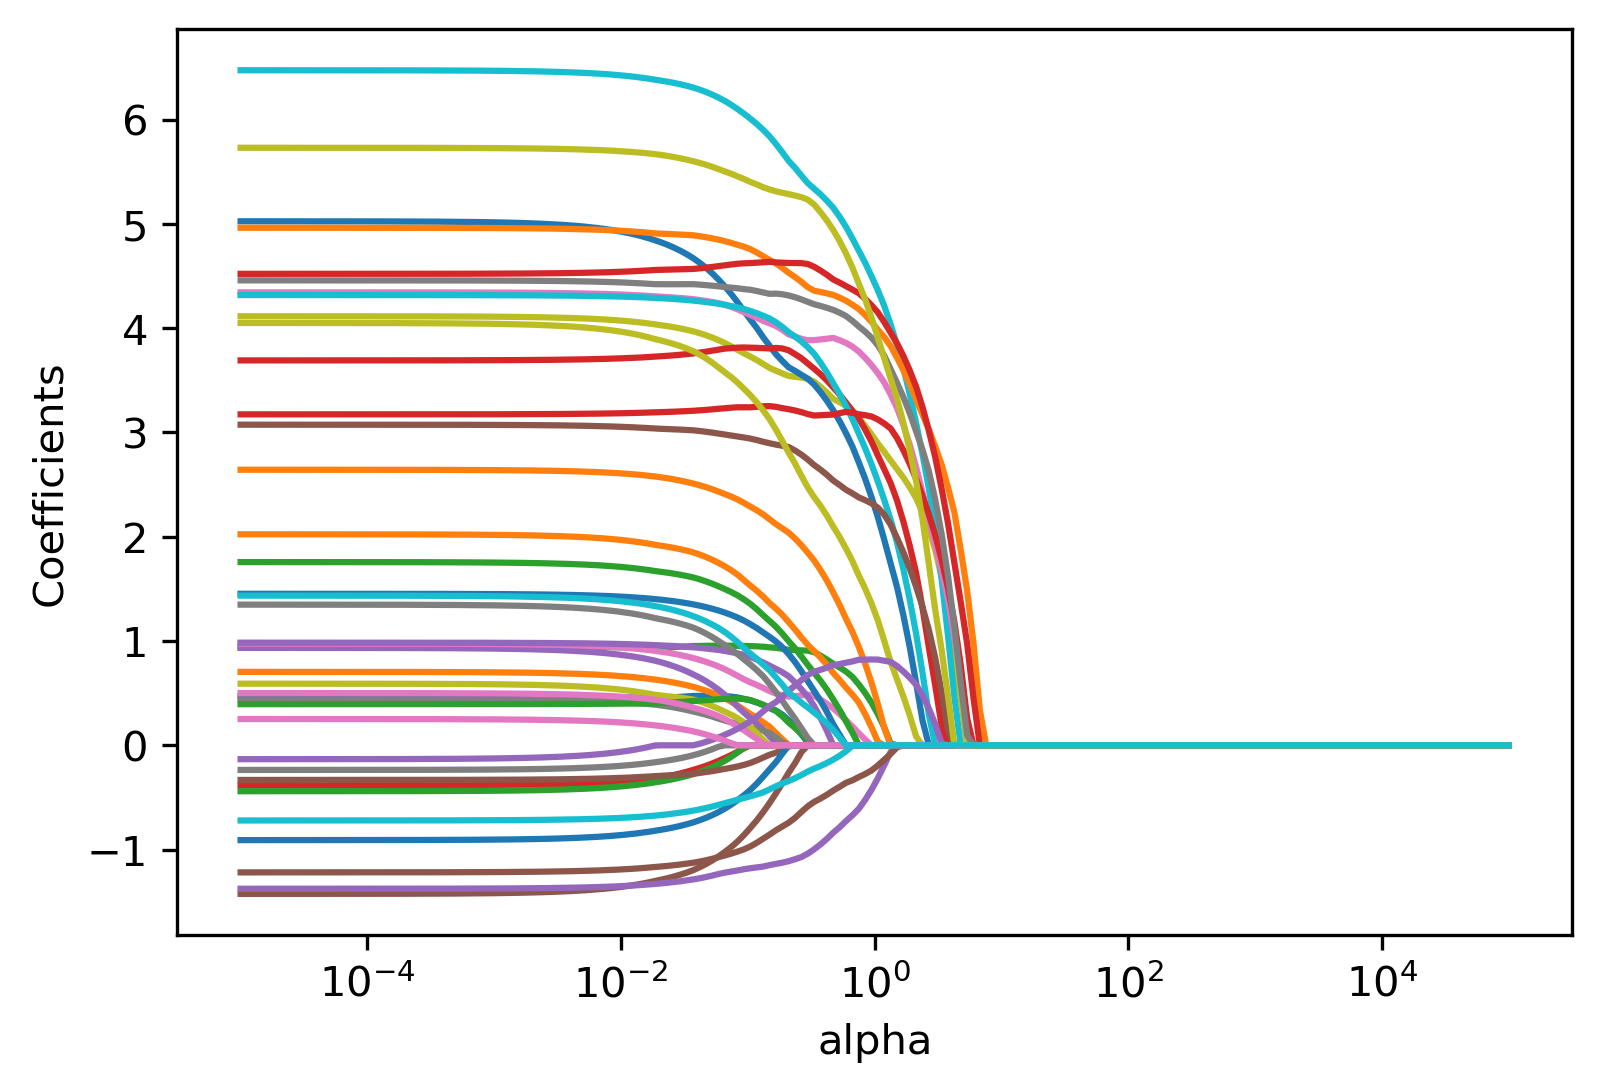

In [9]:
n_alphas = 200 
alphas = np.logspace(-5, 5, n_alphas) #grid search for lambda (aka 'alpha')

scaler = StandardScaler()
lasso = Lasso(normalize=False,fit_intercept=True) #we will pass through alpha values later
pipe = make_pipeline(scaler, lasso)
coefs = []
# print(pipe.get_params().keys()) #reports input names can set (look for the hyper-parameters)
parameters = {'lasso__alpha':alphas}
# model = GridSearchCV(pipe, parameters, scoring='neg_mean_squared_error', cv=n_folds)
# model.fit(X_train,y_train)
for a in alphas:
    pipe.set_params(lasso__alpha=a)
    pipe.fit(X_train, y_train)
    coefs.append(pipe.named_steps['lasso'].coef_)

plt.figure()
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')

plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coefficients');


# plt.figure()
# ax = plt.gca()
# ax.plot(alphas, coefs,'o')
# ax.set_xscale('log')
#
# plt.axis('tight')
# plt.xlabel('alpha')
# plt.ylabel('Coefficients')
# plt.title('Zoomed in')
# plt.xlim(.01,100)


#### Sanity check -- when $\alpha\to \infty$, does the model just use the mean value of the $Y$'s for an intercept?

Check the coefficients $\{\beta_1,\dots,\beta_p \}$ for the _last fitted model_ in the above for loop

In [10]:
pipe.named_steps['lasso'].coef_

array([-0., -0.,  0.,  0., -0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,
        0., -0., -0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,
       -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,
        0.])

Now check the fitted intercept $\beta_0$, and the average of the $Y$'s

In [11]:
pipe.named_steps['lasso'].intercept_

-1.0682650480759426

In [12]:
np.mean(y_train)

-1.0682650480759426

#### Let's take a closer look at the best fitting model.  The above grid search over $\alpha$ (equivalently, $\lambda$) picks a value.  We then _refit_ using the whole training set with that particular $\alpha$, and that will be our final model from Lasso

In [13]:
gs.best_params_

{'lasso__alpha': 0.41987070844439145}

In [14]:
best_alpha = gs.best_params_['lasso__alpha']
print(best_alpha)

0.41987070844439145


Now get a final model for that $\alpha$ (equivalently $\lambda$), using all training data

In [15]:
scaler = StandardScaler()
lasso = Lasso(alpha=best_alpha,normalize=False,fit_intercept=True) #we will pass through alpha values later
pipe = make_pipeline(scaler, lasso)
pipe.fit(X_train, y_train)

best_coef_lasso = pipe.named_steps['lasso'].coef_

# print('The final set of coefficients: ')
# print(best_coef_lasso)

#### Look at coefficients -- though recall lasso coefficients are for standardized X's; focus on which are non-zero

In [16]:
print('\nCoefficients    [true]  [lasso]')
for i in range(n_features):
    print('   Feature %2i:   %5.2f   %.2f'%(i,\
                    coef_true[i],best_coef_lasso[i]))



Coefficients    [true]  [lasso]
   Feature  0:    0.00   0.00
   Feature  1:    0.00   0.00
   Feature  2:   16.81   0.82
   Feature  3:    0.00   0.00
   Feature  4:    0.00   0.00
   Feature  5:    0.00   -0.00
   Feature  6:    0.00   0.40
   Feature  7:    0.00   0.00
   Feature  8:   61.11   3.38
   Feature  9:   72.56   5.22
   Feature 10:   68.88   3.30
   Feature 11:   53.50   4.33
   Feature 12:    0.00   0.00
   Feature 13:   63.40   3.50
   Feature 14:   33.34   0.14
   Feature 15:    0.00   -0.00
   Feature 16:   57.70   3.90
   Feature 17:    0.00   0.00
   Feature 18:    5.57   -0.00
   Feature 19:   69.14   3.58
   Feature 20:    0.00   0.00
   Feature 21:   33.16   1.58
   Feature 22:    0.00   0.00
   Feature 23:   62.39   3.17
   Feature 24:    0.00   -0.90
   Feature 25:   44.12   2.59
   Feature 26:    0.00   -0.00
   Feature 27:    3.75   0.00
   Feature 28:   37.26   2.20
   Feature 29:    0.00   -0.17
   Feature 30:   30.75   0.32
   Feature 31:   13.06   0.77
 

#### How many features did Lasso end up using?

In [17]:
np.count_nonzero(best_coef_lasso)

25

How many features in the true model?

In [18]:
np.count_nonzero(coef_true)

20

How many features total?

In [19]:
print('p='+str(len(coef_true)))

p=40


### Test error 

In [20]:
#on test data
y_pred = pipe.predict(X_test)
mse_test_using_lasso = mean_squared_error(y_test,y_pred)
# print(mse_test_using_coef_true)
print('\nTest set MSE using Lasso coefficients: %.2f'%mse_test_using_lasso)


Test set MSE using Lasso coefficients: 52.42


In [21]:
print('\n(for context) Test set MSE using OLS solution: %.2f'%mse_test_OLS)

print('\nTest set MSE using Lasso: %.2f'%mse_test_using_lasso)

print('\n(for context) Test set MSE using true coef: %.2f'%mse_test_using_coef_true)

print('\n(for context) Test set MSE using only the intercept: %.2f'%mse_test_just_intercept)


(for context) Test set MSE using OLS solution: 61.50

Test set MSE using Lasso: 52.42

(for context) Test set MSE using true coef: 24.74

(for context) Test set MSE using only the intercept: 259.02
